# **First run Ocean parcels on SSC fieldset**

In [6]:
%matplotlib inline
import sys
import numpy as np
import xarray as xr
import numpy as np
import os
from matplotlib import pyplot as plt, animation, rc
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from cartopy import crs, feature

from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4, AdvectionRK4_3D

#rc('animation', html='html5')
from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/Users/jvalenti/MOAD/analysis-jose/notebooks/parcels')
from Kernels import DeleteParticle, Buoyancy
from OP_functions import scatter_particles,scatter_particles,make_prefix

In [7]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/daymonthyear/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, f'{folder}/SalishSea_1{res}_{datestr}')
    
    return prefix

## Load drifters and definitions

In [8]:
# Define paths
paths = {
    'NEMO': '/results2/SalishSea/nowcast-green.201905/',
    'coords': '/Users/jvalenti/MOAD/SSC_masks/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/Users/jvalenti/MOAD/SSC_masks/mesh_mask201702.nc',
    'out': '/Users/jvalenti/MOAD/analysis-jose/notebooks/results/',
    'localnemo' :'/Users/jvalenti/MOAD/data/'
}

In [9]:
# Duration and timestep [s]
length = 10
duration = timedelta(days=length)
dt = 90 #toggle between - or + to pick backwards or forwards

In [10]:
N = 6 # number of deploying locations
n = 100 # 1000   # number of particles per location
# Define Gaussian point cloud in the horizontal
r = 3000   # radius of particle cloud [m]
deg2m = 111000 * np.cos(50 * np.pi / 180)
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], [n,N]).T
# Set a uniform distribution in depth, from dmin to dmax
dmin = 0.
dmax = 5.
zvals = dmin + np.random.random_sample([n,N]).T*(dmax-dmin)

## Simulation

In [11]:
start = datetime(2020, 12, 18)
daterange = [start+timedelta(days=i) for i in range(length)]
# Build filenames
Ulist, Vlist, Wlist = [], [], []
for day in range(duration.days):
    path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
    #print (path_NEMO)
    Ulist.append(path_NEMO + '_grid_U.nc')
    Vlist.append(path_NEMO + '_grid_V.nc')
    Wlist.append(path_NEMO + '_grid_W.nc')

# Load NEMO forcing : note, depth aware but no vertical advection, particles stay at their original depth
filenames = {
    'U': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Ulist},
    'V': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Vlist},
    'W': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Wlist},
}
variables = {'U': 'vozocrtx', 'V': 'vomecrty','W': 'vovecrtz'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}

#bring salish sea results into field_set
#field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

### Change name for each run!!

In [12]:
# from paramiko import SSHClient
# from scp import SCPClient

# ssh = SSHClient()
# ssh.load_system_host_keys()
# ssh.connect('salish.eos.ubc.ca')

# # SCPCLient takes a paramiko transport as an argument
# scp = SCPClient(ssh.get_transport())

# #scp.put('test.txt', 'test2.txt')
# scp.get(filenames['U']['data']+filenames['V']['data']+filenames['W']['data'],local_path='/Users/jvalenti/MOAD/data')

# # Uploading the 'test' directory with its content in the
# # '/home/user/dump' remote directory
# #scp.put('test', recursive=True, remote_path='/home/user/dump')

# scp.close()

In [7]:
# start = datetime(2020, 12, 18)
# daterange = [start+timedelta(days=i) for i in range(length)]
# # Build filenames
# Ulist, Vlist, Wlist = [], [], []
# for day in range(duration.days):
#     path_NEMO = make_prefix(start + timedelta(days=day), paths['localnemo'])
#     print (path_NEMO)
#     Ulist.append(path_NEMO + '_grid_U.nc')
#     Vlist.append(path_NEMO + '_grid_V.nc')
#     Wlist.append(path_NEMO + '_grid_W.nc')

# # Load NEMO forcing : note, depth aware but no vertical advection, particles stay at their original depth
# filenames = {
#     'U': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Ulist},
#     'V': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Vlist},
#     'W': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Wlist},
# }
# variables = {'U': 'vozocrtx', 'V': 'vomecrty','W': 'vovecrtz'}
# dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}

# #bring salish sea results into field_set
# field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

In [8]:
# Set output file name.  Maybe change for each run
fn = f'storm-local-MP' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

/Users/jvalenti/MOAD/analysis-jose/notebooks/results/storm-local-MP20201218_1n_20201228_1n.nc


### Set particle location

In [9]:
lon = np.zeros([N,n])
lat = np.zeros([N,n])
# Execute run
clon, clat = [-123.901172,-125.155849,-123.207648,-122.427508,-123.399769,-123.277731], [49.186308,49.975326,49.305448,47.622403,48.399420,49.11602]  # choose horizontal centre of the particle cloud
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])
z = zvals

In [ ]:
# pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=2))
# #pset.computeTimeChunk(allow_time_extrapolation=1)
# pset.execute(
#     pset.Kernel(AdvectionRK4_3D), runtime=duration, dt=dt,
#     output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
#     recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
# )

In [13]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

Text(0.5, 0, 'Longitude')

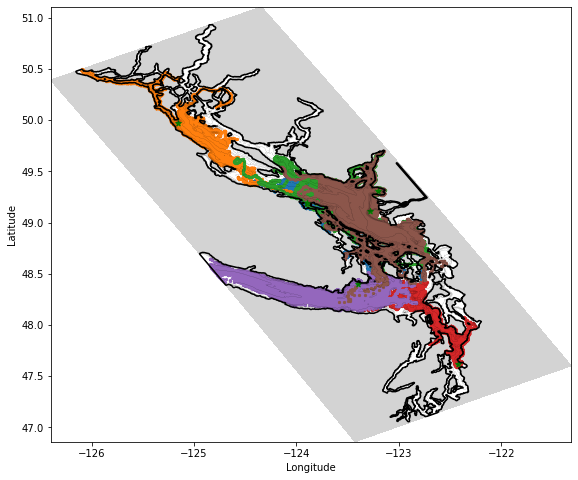

In [16]:
fig, ax = plt.subplots(figsize=(19, 8))
ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_aspect(1/1)
nmin, nmax = 0, -1
scatter_particles(ax, N,n, nmin, nmax, ds.lat,ds.lon)
ax.scatter(clon,clat,c='g', marker='*', linewidths=1)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

Text(0.5, 0, 'Longitude')

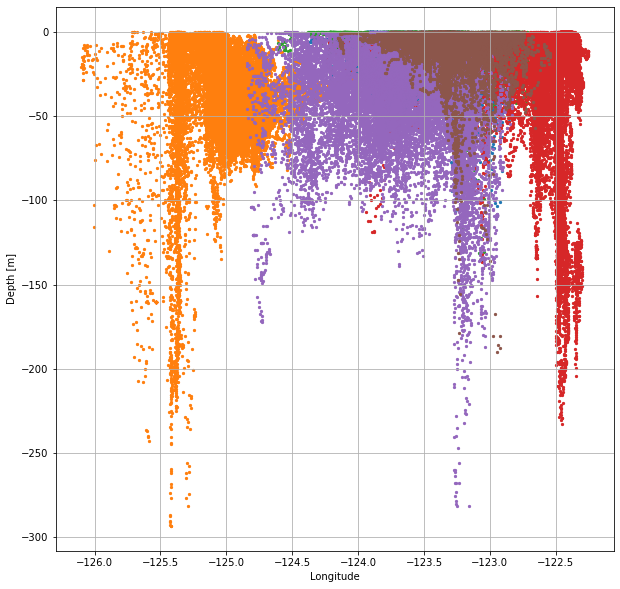

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter_particles(ax, N,n, nmin, nmax, -ds.z,ds.lon)
ax.grid()
plt.ylabel('Depth [m]')
plt.xlabel('Longitude')

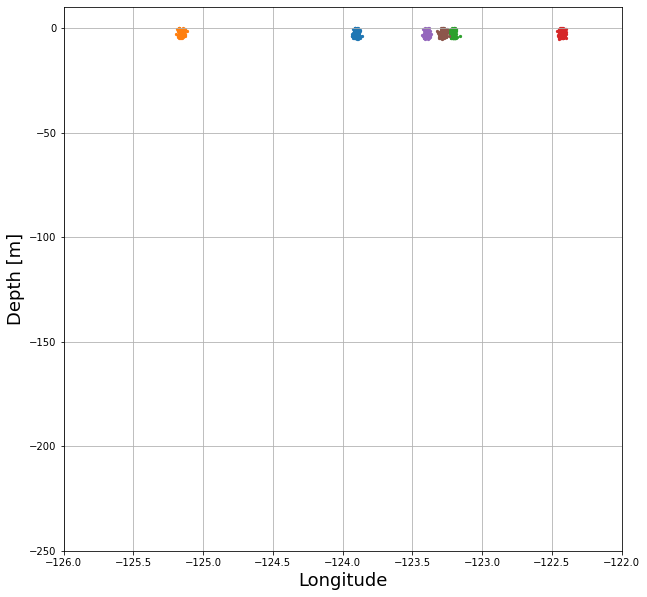

In [19]:
fpd = 1
fig = plt.figure(figsize=(10, 10))

def animate(frames):

    plt.clf()
    ax = fig.add_subplot(111)
    oo = scatter_particles(ax, N,n, frames, frames, -ds.z,ds.lon)
    #ax.grid()
    plt.ylabel('Depth [m]',fontsize=18)
    plt.xlabel('Longitude',fontsize=18)
    plt.ylim([-250,10])
    plt.xlim([-126,-122])
    plt.grid()
    return oo


ani = animation.FuncAnimation(fig, animate, frames=np.arange(0,len(ds.lon[0,:]),fpd))
ani

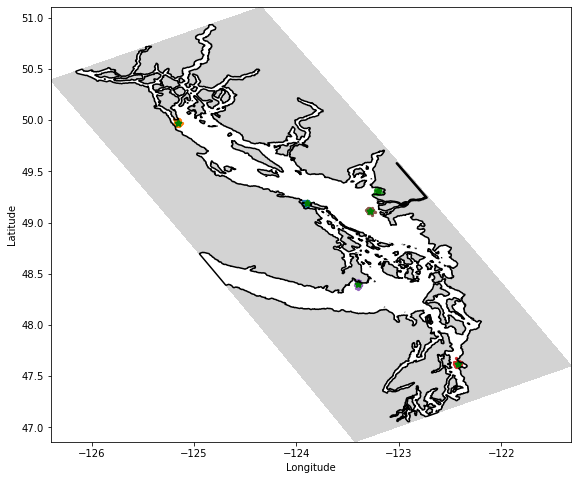

In [23]:
fpd = 1
fig = plt.figure(figsize=(19, 8))
def animate(frames):

    plt.clf()
    ax = fig.add_subplot(111)
    #ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
    ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_aspect(1/1)
    ss = scatter_particles(ax, N,n, frames,frames, ds.lat,ds.lon)
    #ax.grid()
    ax.scatter(clon,clat,c='g', marker='*', linewidths=2)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    #plt.ylim([-250,10])
    #plt.xlim([-126,-122])
    return ss


anim = animation.FuncAnimation(fig, animate, frames=np.arange(0,len(ds.lon[0,:]),fpd))
#HTML(ani.to_html5_video())
anim

/Users/jvalenti/conda_envs/parcels/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/jvalenti/conda_envs/parcels/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/jvalenti/conda_envs/parcels/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


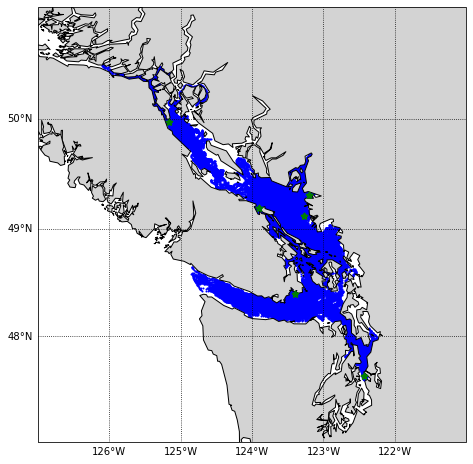

In [24]:
# Make map
fig, ax = plt.subplots(figsize=(19, 8), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([-127, -121, 47, 51], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', facecolor='lightgray'),zorder=2)
ax.add_feature(feature.RIVERS, edgecolor='k')

gl = ax.gridlines(
    linestyle=':', color='k', draw_labels=True,
    xlocs=range(-126, -121), ylocs=range(47, 52),zorder=5)
gl.top_labels, gl.right_labels = False, False

nmin, nmax = 0, -1
ax.scatter(ds.lon[:, nmin:nmax], ds.lat[:, nmin:nmax],c='b',s=1,transform=crs.PlateCarree(),zorder=1)
ax.scatter(clon,clat,c='g', marker='*', linewidth=2,transform=crs.PlateCarree(),zorder=4)
#ax.set_ylabel(ylabel='Latitude')#NOT WORKING
#ax.set_xlabel(xlabel='Longitude')#NOT WORKING